In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
monero = pd.read_csv('/content/drive/My Drive/coin_Monero.csv')
cardano = pd.read_csv('/content/drive/My Drive/coin_Cardano.csv')
dogecoin = pd.read_csv('/content/drive/My Drive/coin_Dogecoin.csv')
bitcoin = pd.read_csv('/content/drive/My Drive/coin_Bitcoin.csv')
ethereum = pd.read_csv('/content/drive/My Drive/coin_Ethereum.csv')
# monero = pd.read_csv('coin_Monero.csv')
# cardano = pd.read_csv('coin_Cardano.csv')
# dogecoin = pd.read_csv('coin_Dogecoin.csv')
# bitcoin = pd.read_csv('coin_Bitcoin.csv')
# ethereum = pd.read_csv('coin_Ethereum.csv')

In [6]:
bitcoin.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [7]:
import datetime 

In [8]:
def convert_data(data, name):
  data['Date'] = data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
  minimum_day = data['Date'].min()
  data['Day'] = data['Date'] - minimum_day
  data['Day'] = data['Day'].apply(lambda x: x.days)
  data[name] = data['Close']
  data.drop('Close', inplace=True, errors='ignore')
  return data

In [9]:
data = pd.DataFrame()
data = convert_data(bitcoin, 'bitcoin')
data = pd.merge(convert_data(dogecoin, 'dogecoin'), data, on=['Day'])
data = pd.merge(convert_data(monero, 'monero'), data, on=['Day'])
data = pd.merge(convert_data(cardano, 'cardano'), data, on=['Day'])
data = pd.merge(convert_data(ethereum, 'ethereum'), data, on=['Day'])
data = data[['Day', 'dogecoin', 'cardano', 'bitcoin', 'monero', 'ethereum']]

In [10]:
data.head()

,Day,dogecoin,cardano,bitcoin,monero,ethereum
0,0,0.000205,0.025932,144.539993,2.09558,0.753325
1,1,0.000269,0.020816,139.000000,2.96302,0.701897
2,2,0.000362,0.021931,116.989998,3.70245,0.708448
3,3,0.001162,0.021489,105.209999,3.13856,1.067860
4,4,0.000704,0.018539,97.750000,3.02186,1.217440


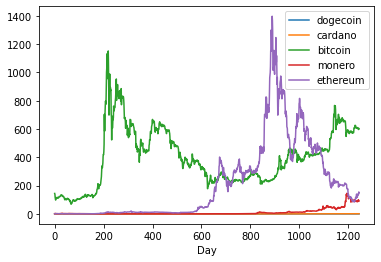

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = data['Day']
data.plot(x='Day')
plt.show()

## Step 1

Choose about 3-6 variables from your dataset (2-3 – target variables, the rest -
predictors).


-----------


Target variables: 'cardano', 'dogecoin'


Predictors: 'bitcoin', 'monero', 'ethereum'

In [12]:
targets = ['cardano', 'dogecoin']
predictors = ['bitcoin', 'monero', 'ethereum']
all_vars = targets + predictors

## Step 2

Analyze stationarity of a process (for mathematical expectation and variance) for all
chosen variables. Make them more stationary if needed.

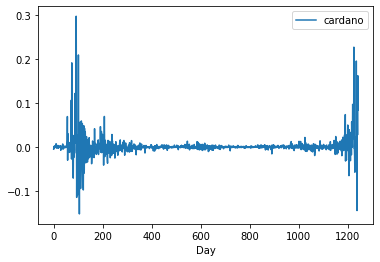

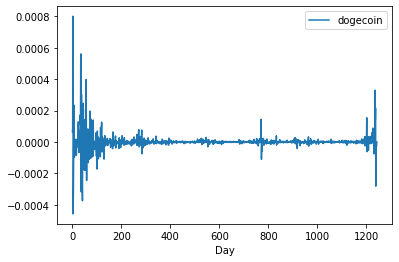

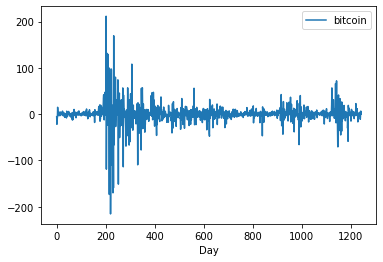

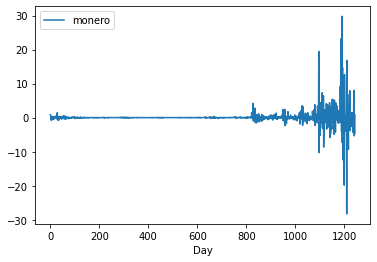

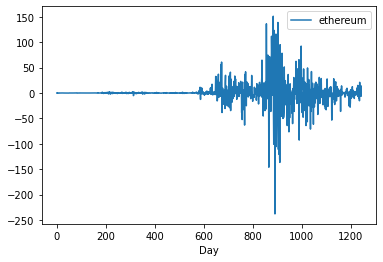

In [13]:
# trend subtraction using differences
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = data.copy()
for var in all_vars:
  diff_data[var] = difference(data[var], interval=1)
  diff_data.plot(x='Day', y=var)
diff_data.fillna(value=0, inplace=True)

In [14]:
# find the trend
def trendline(data, order=9):
    # polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

--------------------------
cardano


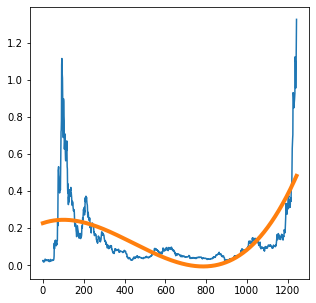

--------------------------
dogecoin


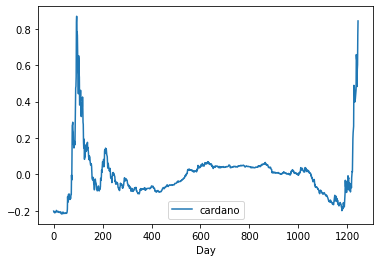

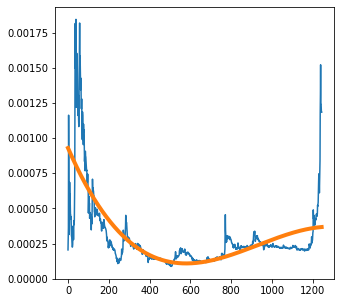

--------------------------
bitcoin


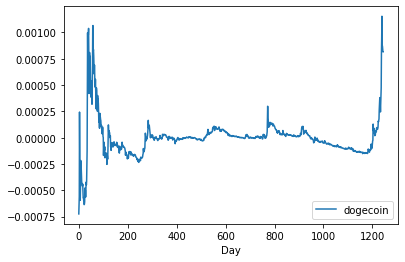

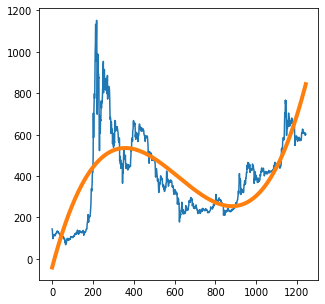

--------------------------
monero


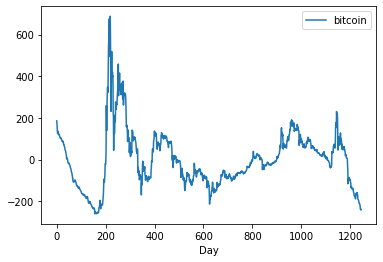

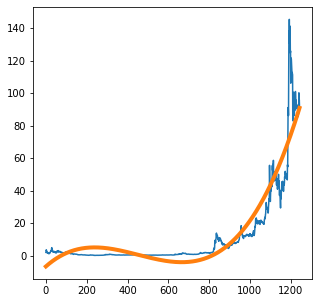

--------------------------
ethereum


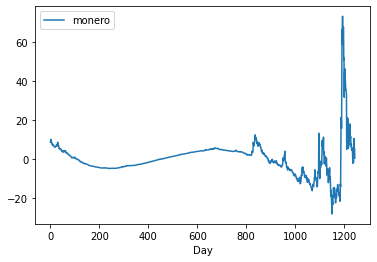

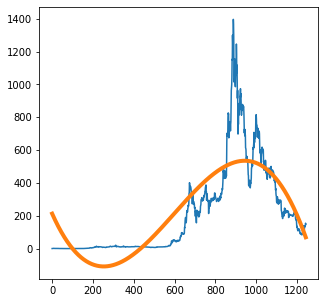

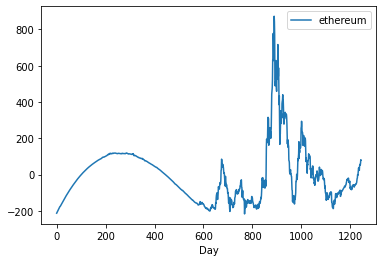

In [15]:
trendless_data = data.copy()
for var in all_vars:
  print('--------------------------')
  print(var)
  trend = trendline(data[var], 3)
  plt.figure(figsize=(5, 5))
  plt.plot(data[var])
  plt.plot(trend, linewidth=4)
  plt.show()
  trendless_data[var] = data[var] - trend
  trendless_data.plot(x='Day', y=var)

## Step 3. 

Analyze covariance or correlation function for chosen target variables and mutual
correlation functions among predictors and targets.

In [16]:
import scipy
import scipy.stats

def pearson_data(x, y, a=0.05):
  r, p = scipy.stats.pearsonr(x, y)
  r_z = np.arctanh(r)
  se = 1 / np.sqrt(x.size-3)
  z = scipy.stats.norm.ppf(1-a/2)
  lo_z, hi_z = r_z - z * se, r_z + z * se
  lo, hi = np.tanh((lo_z, hi_z))
  return r, p, lo, hi

def print_pearson(data, var_x, var_y):
  x = data[var_x]
  y = data[var_y]
  r, p, lo, hi = pearson_data(x, y)
  print(var_x + " and " + var_y + ": pearson: %s,\
   significance level: %s, \
   confidence interval: [%s .. %s]" % (r, p, lo, hi))

In [17]:
print_pearson(data, targets[0], targets[1])
for target in targets:
  for predictor in predictors:
    print('---------------')
    print('Raw data:')
    print_pearson(data, target, predictor)
    print('Differences:')
    print_pearson(diff_data, target, predictor)
    print('Without polynomial trend:')
    print_pearson(trendless_data, target, predictor)

cardano and dogecoin: pearson: 0.4218001156577606,   significance level: 7.785053161225673e-55,    confidence interval: [0.375012216081322 .. 0.46644452845737805]
---------------
Raw data:
cardano and bitcoin: pearson: 0.05274984424807488,   significance level: 0.06289516121849137,    confidence interval: [-0.0028379473065140255 .. 0.10801264310488336]
Differences:
cardano and bitcoin: pearson: 0.031905093004345624,   significance level: 0.26081797594446143,    confidence interval: [-0.023716433830249618 .. 0.08732970525189153]
Without polynomial trend:
cardano and bitcoin: pearson: -0.3152371894556594,   significance level: 4.217187092518238e-30,    confidence interval: [-0.36443155873942185 .. -0.26428823744983304]
---------------
Raw data:
cardano and monero: pearson: 0.4070090076890961,   significance level: 7.919100798877538e-51,    confidence interval: [0.3595633430414428 .. 0.45235558693388345]
Differences:
cardano and monero: pearson: 0.04610063536621457,   significance level: 

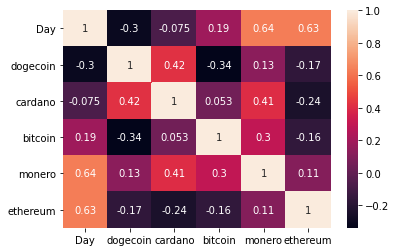

In [18]:
import seaborn as sns
sns.heatmap(data.corr(method='pearson'), annot=True)

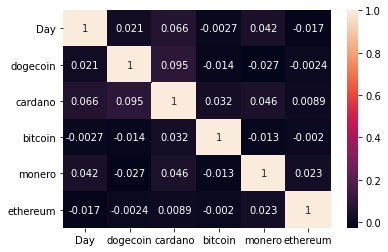

In [19]:
sns.heatmap(diff_data.corr(method='pearson'), annot=True)

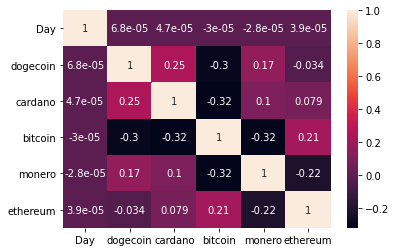

In [20]:
sns.heatmap(trendless_data.corr(method='pearson'), annot=True)

## Step 4

Filter high frequencies (noise) with chosen 2 filters for target variables.

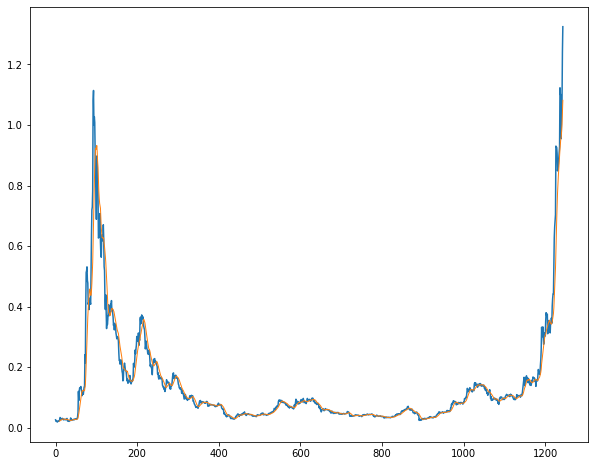

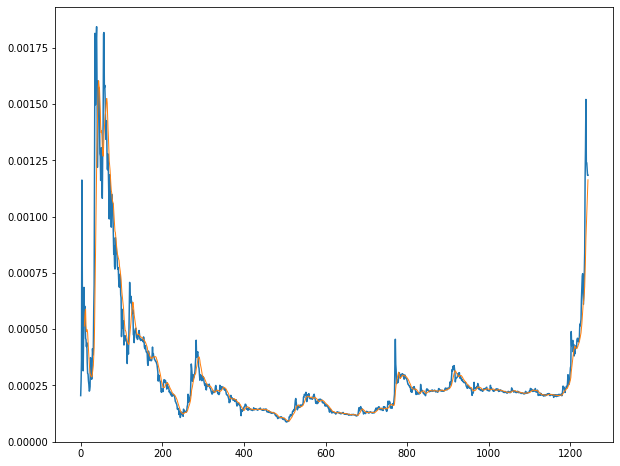

In [21]:
# rol mean filtering

for var in targets:
  rol_mean = data[var].rolling(10).mean()
  plt.figure(figsize=(10, 8))
  plt.plot(data[var])
  plt.plot(rol_mean, linewidth=1)

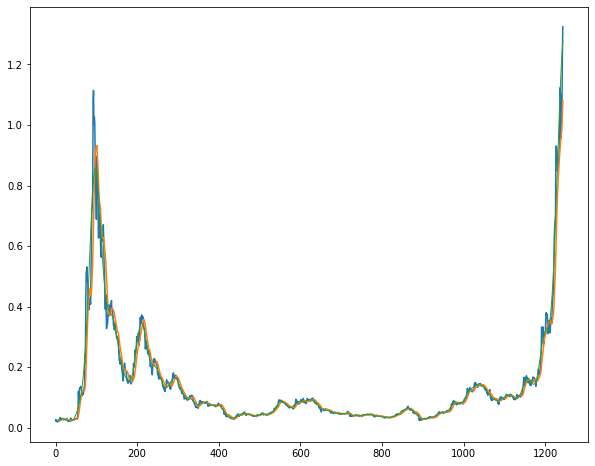

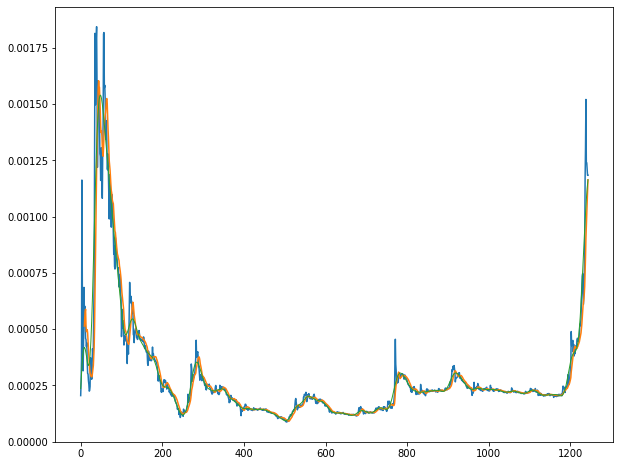

In [22]:
from scipy import signal

fs = 1000 # sampling frequency
fc = 30  # cut frequency
w = fc / (fs / 2) # normalisation

for target in targets:
  b, a = signal.butter(5, w, 'low')
  output_btw = signal.filtfilt(b, a, data[target])
  plt.figure(figsize=(10, 8))
  plt.plot(data[target])
  rol_mean = data[target].rolling(10).mean()
  plt.plot(rol_mean)
  plt.plot(output_btw, linewidth=1)

## Step 5

Estimate spectral density function for with and without filtering.

cardano


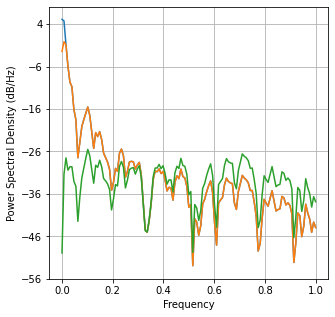

dogecoin


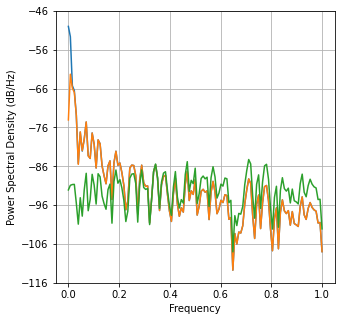

bitcoin


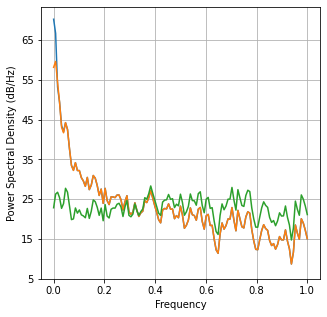

monero


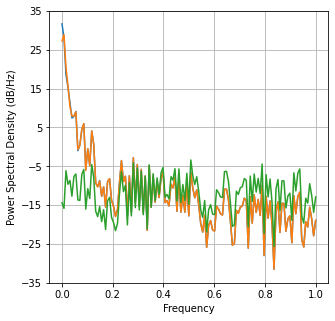

ethereum


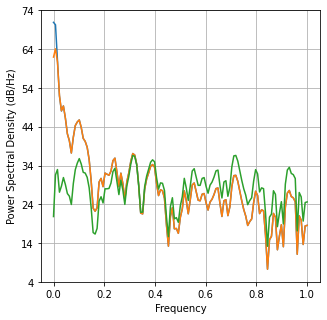

In [23]:
import matplotlib.pyplot

for var in all_vars:
  plt.figure(figsize=(5,5))
  print(var)
  _ = matplotlib.pyplot.psd(var, data=data)
  _ = matplotlib.pyplot.psd(var, data=trendless_data)
  _ = matplotlib.pyplot.psd(var, data=diff_data)
  plt.show()

## Step 6

Built auto-regression model filtered and non-filtered data. To analyze residual error
and to define appropriate order of model.

In [24]:
!pip3 install statsmodels

In [25]:
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                             ARIMA Model Results                              
Dep. Variable:              D.bitcoin   No. Observations:                 1243
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5650.876
Method:                       css-mle   S.D. of innovations             22.809
Date:                Mon, 19 Apr 2021   AIC                          11315.751
Time:                        08:08:54   BIC                          11351.628
Sample:                             1   HQIC                         11329.242
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3657      0.655      0.558      0.577      -0.918       1.650
ar.L1.D.bitcoin     0.0053      0.028      0.189      0.850      -0.050       0.061
ar.L2.D.bitcoin    -0.0837      

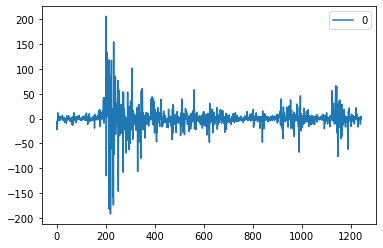

In [28]:
model = ARIMA(
    data['bitcoin'],
    order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()


# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# model_fit.predict(data['bitcoin'])

In [29]:
from sklearn.metrics import r2_score
print("R2 score:", 
      r2_score(data['bitcoin'], model_fit.predict(data['bitcoin'])))

KeyError: ignored